In [40]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='927ff46c-2c91-4a1f-90fd-05918ac1f451', project_access_token='p-03b5d194a19410ee95fe6c578b0327d8f36d8d3a')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: UNINASSAU

### Instalando bibliotecas

In [4]:
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)


In [5]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.2.0)


In [6]:
# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para trabalhar com JSON
import json

# Pacote para realizar requisições HTTP
import requests

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos e construção de pipelines
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Método para criação de modelos baseados em árvores de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Classe para a criação de uma pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Pacotes do scikit-learn para avaliação de modelos
# Métodos para validação cruzada do modelo criado
from sklearn.model_selection import KFold, cross_validate

## Download dos conjuntos de dados em formato .csv

In [7]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/maratonadev-br/desafio-2-2020/master/Assets/Data/dataset_desafio_2.csv
df_training_dataset = pd.read_csv(r'dataset_desafio_2.csv')
df_training_dataset.tail()

--2020-09-06 16:01:04--  https://raw.githubusercontent.com/maratonadev-br/desafio-2-2020/master/Assets/Data/dataset_desafio_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1500234 (1.4M) [text/plain]
Saving to: ‘dataset_desafio_2.csv.1’

100%[======================================>] 1,500,234   --.-K/s   in 0.04s   

2020-09-06 16:01:04 (33.2 MB/s) - ‘dataset_desafio_2.csv.1’ saved [1500234/1500234]



MATRICULA                                NOME  REPROVACOES_DE  \
19995     856673              Laércio Mário da Silva               0   
19996     576100                  Cibele Quésia Poza               1   
19997     888739                Marcielle Chale Bape               0   
19998     722743               Suzanne Mirian Mourão               0   
19999     417268  Maria Isaiane da Silva Luwequisman               0   

       REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  NOTA_DE  NOTA_EM  \
19995               0               0               0      7.0      7.9   
19996               1               1               1      0.0      0.0   
19997               0               0               0      7.9      7.6   
19998               0               1               1      6.3      5.1   
19999               0               1               1      7.0      7.3   

       NOTA_MF  NOTA_GO  INGLES  H_AULA_PRES  TAREFAS_ONLINE  FALTAS  \
19995      5.8      7.0     1.0            9               5       6   
19996      0.0      NaN     1.0            3               2       5   
19997      8.3      7.2     NaN            8               3       1   
19998      0.0      0.0     1.0            3               2       6   
19999      0.0      0.0     NaN            3               0       6   

            PERFIL  
19995       EXATAS  
19996  DIFICULDADE  
19997    EXCELENTE  
19998  DIFICULDADE  
19999  DIFICULDADE

Temos 15 colunas presentes no dataset fornecido, sendo dezessete delas variáveis características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis características são:

    MATRICULA       - número de matrícula do estudante
    NOME            - nome completo do estudante
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    REPROVACOES_GO  - número de reprovações na disciplina de ``Gestão Operacional``
    NOTA_DE         - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    NOTA_EM         - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    NOTA_MF         - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    NOTA_GO         - média simples das notas do aluno na disciplina de ``Gestão Operacional`` (0-10)
    INGLES          - variável binária que indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não).
    H_AULA_PRES     - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE  - número de tarefas online entregues pelo estudante
    FALTAS          - número de faltas acumuladas do estudante (todas disciplinas)
    
A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "HUMANAS"        - Estudante necessita de mentoria exclusivamente em matérias com conteúdo de ciências humanas
        "EXATAS"         - Estudante necessita de mentoria apenas em disciplinas com conteúdo de ciências exatas
        "DIFICULDADE"    - Estudante necessita de mentoria em duas ou mais disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

### Explorando os dados fornecidos

Podemos continuar a exploração dos dados fornecidos com a função ``info()``:

In [8]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
MATRICULA         20000 non-null int64
NOME              20000 non-null object
REPROVACOES_DE    20000 non-null int64
REPROVACOES_EM    20000 non-null int64
REPROVACOES_MF    20000 non-null int64
REPROVACOES_GO    20000 non-null int64
NOTA_DE           20000 non-null float64
NOTA_EM           20000 non-null float64
NOTA_MF           20000 non-null float64
NOTA_GO           16284 non-null float64
INGLES            16372 non-null float64
H_AULA_PRES       20000 non-null int64
TAREFAS_ONLINE    20000 non-null int64
FALTAS            20000 non-null int64
PERFIL            20000 non-null object
dtypes: float64(5), int64(8), object(2)
memory usage: 2.3+ MB


É notado que existem variáveis do tipo ``float64`` (números "decimais"), variáveis do tipo ``int64`` (números inteiros) e do tipo ``object`` (nesse caso são *strings*, ou texto). 

Como a maioria dos algoritmos de aprendizado estatístico supervisionado só aceita valores numéricos como entrada, é necessário então o pré-processamento das variáveis do tipo "object" antes de usar esse dataset como entrada para o treinamento de um modelo. Também é notado que existem valores faltantes em várias colunas. Esses valores faltantes também devem ser tratados antes de serem construídos modelos com esse conjunto de dados base.

A função ``describe()`` gera várias informações sobre as variáveis numéricas que também podem ser úteis:

In [6]:
df_training_dataset.describe()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  \
count   20000.000000    20000.000000    20000.000000    20000.000000   
mean   551148.271400        0.242850        0.242850        0.297650   
std    259488.766584        0.615055        0.615055        0.672813   
min    100003.000000        0.000000        0.000000        0.000000   
25%    326554.250000        0.000000        0.000000        0.000000   
50%    550630.000000        0.000000        0.000000        0.000000   
75%    775524.750000        0.000000        0.000000        0.000000   
max    999995.000000        3.000000        3.000000        3.000000   

       REPROVACOES_GO       NOTA_DE       NOTA_EM       NOTA_MF       NOTA_GO  \
count    20000.000000  20000.000000  20000.000000  20000.000000  16284.000000   
mean         0.293350      5.196560      5.080285      4.817630      4.534101   
std          0.661829      2.522545      2.523928      2.734775      2.509209   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      5.200000      4.900000      4.700000      4.500000   
50%          0.000000      6.200000      5.900000      5.500000      5.400000   
75%          0.000000      6.700000      6.700000      6.500000      6.200000   
max          3.000000      9.000000      9.400000     11.500000     10.000000   

             INGLES   H_AULA_PRES  TAREFAS_ONLINE        FALTAS  
count  16372.000000  20000.000000    20000.000000  20000.000000  
mean       0.646286      5.102950        3.140300      4.060600  
std        0.478136      4.118422        1.854909      1.674714  
min        0.000000      0.000000        0.000000      1.000000  
25%        0.000000      2.000000        2.000000      3.000000  
50%        1.000000      4.000000        3.000000      4.000000  
75%        1.000000      6.000000        5.000000      6.000000  
max        1.000000     25.000000        7.000000      8.000000

### Visualizações

Para visualizar o dataset fornecido, podemos utilizar as bibliotecas ``matplotlib`` e ``seaborn``:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

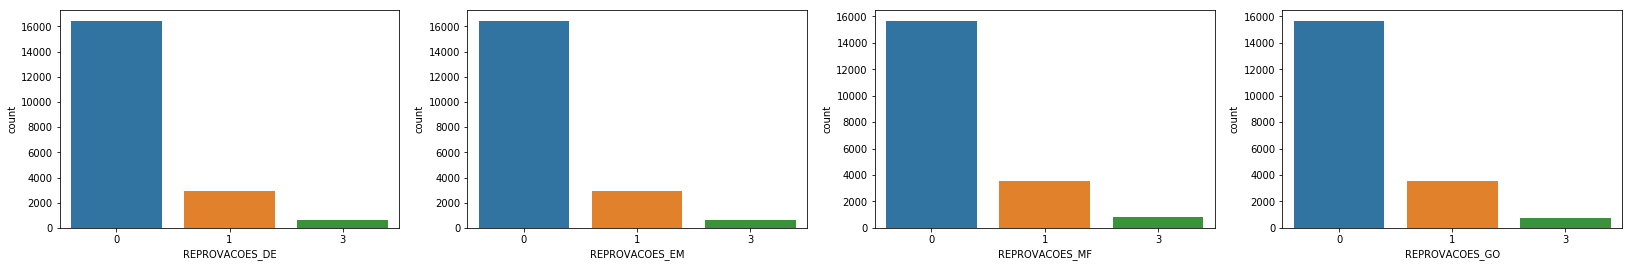

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='REPROVACOES_DE', data=df_training_dataset)
sns.countplot(ax=axes[1], x='REPROVACOES_EM', data=df_training_dataset)
sns.countplot(ax=axes[2], x='REPROVACOES_MF', data=df_training_dataset)
sns.countplot(ax=axes[3], x='REPROVACOES_GO', data=df_training_dataset)

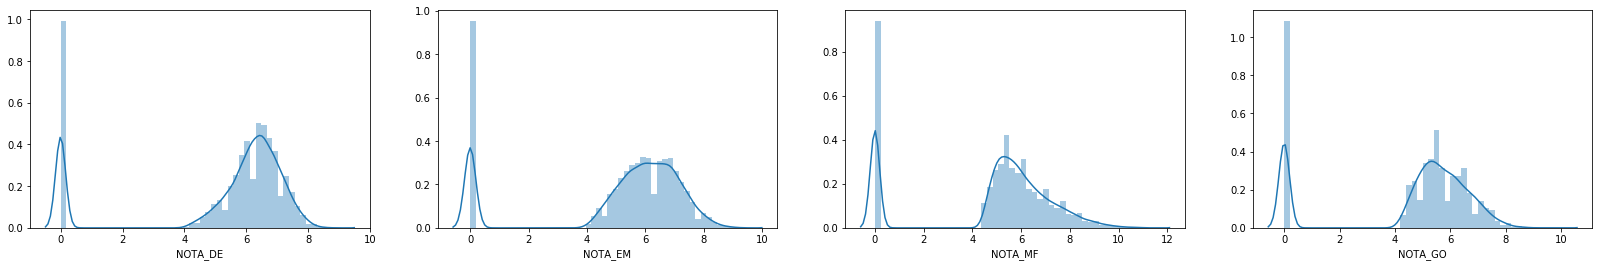

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.distplot(df_training_dataset['NOTA_DE'], ax=axes[0])
sns.distplot(df_training_dataset['NOTA_EM'], ax=axes[1])
sns.distplot(df_training_dataset['NOTA_MF'], ax=axes[2])
sns.distplot(df_training_dataset['NOTA_GO'].dropna(), ax=axes[3])

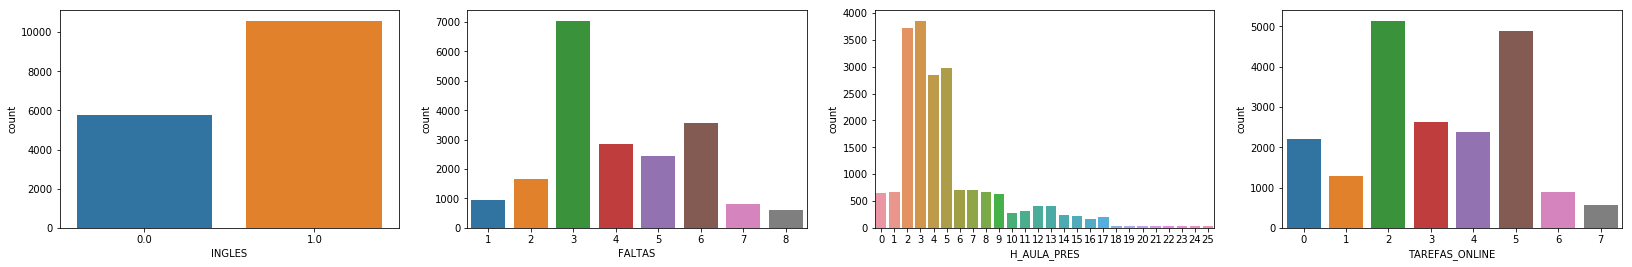

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='INGLES', data=df_training_dataset)
sns.countplot(ax=axes[1], x='FALTAS', data=df_training_dataset)
sns.countplot(ax=axes[2], x='H_AULA_PRES', data=df_training_dataset)
sns.countplot(ax=axes[3], x='TAREFAS_ONLINE', data=df_training_dataset)

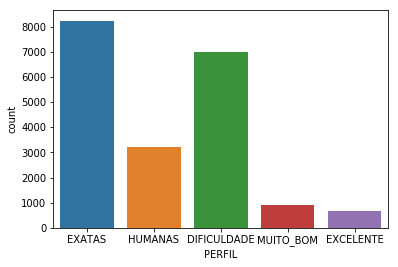

In [12]:
fig = plt.plot()
sns.countplot(x='PERFIL', data=df_training_dataset)

## ** ATENÇÃO **

Você pode notar pela figura acima que este dataset é desbalanceado, isto é, a quantidade de amostras para cada classe que desejamos classificar é bem discrepante. O participante é livre para adicionar ou remover **LINHAS** no dataset fornecido, inclusive utilizar bibliotecas para balanceamento com ``imblearn``.

<hr>

### Realizando o pré-processamento dos dados

#### Transformação 1: excluindo colunas do dataset

Para a criação de uma transformação de dados personalizada no scikit-learn, é necessária basicamente a criação de uma classe com os métodos ``transform`` e ``fit``. No método transform será executada a lógica da nossa transformação.

Na próxima célula é apresentado o código completo de uma transformação ``DropColumns`` para a remoção de colunas de um DataFrame pandas.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

Para aplicar essa transformação em um DataFrame pandas, basta instanciar um objeto *DropColumns* e chamar o método transform().

In [14]:
# Instanciando uma transformação DropColumns
rm_columns = DropColumns(
    columns=["NOME", "INGLES"]  # Essa transformação recebe como parâmetro uma lista com os nomes das colunas indesejadas
)

print(rm_columns)

DropColumns(columns=['NOME', 'INGLES'])


In [15]:
# Visualizando as colunas do dataset original
print("Colunas do dataset original: \n")
print(df_training_dataset.columns)

Colunas do dataset original: 

Index(['MATRICULA', 'NOME', 'REPROVACOES_DE', 'REPROVACOES_EM',
       'REPROVACOES_MF', 'REPROVACOES_GO', 'NOTA_DE', 'NOTA_EM', 'NOTA_MF',
       'NOTA_GO', 'INGLES', 'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS',
       'PERFIL'],
      dtype='object')


In [16]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df_training_dataset)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_training_dataset_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_training_dataset
    ),
)

In [17]:
# Visualizando as colunas do dataset transformado
print("Colunas do dataset após a transformação ``DropColumns``: \n")
print(df_training_dataset_2.columns)

Colunas do dataset após a transformação ``DropColumns``: 

Index(['MATRICULA', 'REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF',
       'REPROVACOES_GO', 'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO',
       'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS', 'PERFIL'],
      dtype='object')


Nota-se que a coluna "NOME" foi removida e nosso dataset agora poossui apenas 17 colunas.

#### Transformação 2: tratando dados faltantes

Para tratar os dados faltantes em nosso conjunto de dados, iremos agora utilizar uma transformação pronta da biblioteca scikit-learn, chamada **SimpleImputer**.

Essa transformação permite diversas estratégias para o tratamento de dados faltantes. A documentação oficial pode ser encontrada em: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Neste exemplo iremos simplesmente transformar todos os valores faltantes em zero.

In [18]:
# Criação de um objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
    verbose=0,
    copy=True
)

In [19]:
# Visualizando os dados faltantes do dataset após a primeira transformação (df_data_2)
print("Valores nulos antes da transformação SimpleImputer: \n\n{}\n".format(df_training_dataset_2.isnull().sum(axis = 0)))

Valores nulos antes da transformação SimpleImputer: 

MATRICULA            0
REPROVACOES_DE       0
REPROVACOES_EM       0
REPROVACOES_MF       0
REPROVACOES_GO       0
NOTA_DE              0
NOTA_EM              0
NOTA_MF              0
NOTA_GO           3716
H_AULA_PRES          0
TAREFAS_ONLINE       0
FALTAS               0
PERFIL               0
dtype: int64



In [20]:
# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_data_2 (resultado da primeira transformação)
si.fit(X=df_training_dataset_2)

# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_3)
df_training_dataset_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_training_dataset_2
    ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
    columns=df_training_dataset_2.columns  # as colunas originais devem ser conservadas nessa transformação
)

In [21]:
# Visualizando os dados faltantes do dataset após a segunda transformação (SimpleImputer) (df_data_3)
print("Valores nulos no dataset após a transformação SimpleImputer: \n\n{}\n".format(df_training_dataset_3.isnull().sum(axis = 0)))

Valores nulos no dataset após a transformação SimpleImputer: 

MATRICULA         0
REPROVACOES_DE    0
REPROVACOES_EM    0
REPROVACOES_MF    0
REPROVACOES_GO    0
NOTA_DE           0
NOTA_EM           0
NOTA_MF           0
NOTA_GO           0
H_AULA_PRES       0
TAREFAS_ONLINE    0
FALTAS            0
PERFIL            0
dtype: int64



Nota-se que não temos mais nenhum valor faltante no nosso conjunto de dados :)

Vale salientar que nem sempre a alteração dos valores faltantes por 0 é a melhor estratégia. O participante é incentivado a estudar e implementar estratégias diferentes de tratamento dos valores faltantes para aprimorar seu modelo e melhorar sua pontuação final.

### Treinando um modelo de classificação

Finalizado o pré-processamento, já temos o conjunto de dados no formato necessário para o treinamento do nosso modelo:

In [22]:
df_training_dataset_3.head()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
0     502375               0               0               0               0   
1     397093               0               0               0               0   
2     915288               0               0               0               0   
3     192652               1               3               1               1   
4     949491               1               3               1               1   

   NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  H_AULA_PRES  TAREFAS_ONLINE  FALTAS  \
0      6.2      5.8      4.6      5.9            2               4       3   
1      6.0      6.2      5.2      4.5            2               4       3   
2      7.3      6.7      7.1      7.2            5               0       3   
3      0.0      0.0      0.0      0.0            4               4       4   
4      0.0      0.0      0.0      0.0            5               2       5   

        PERFIL  
0       EXATAS  
1       EXATAS  
2      HUMANAS  
3  DIFICULDADE  
4  DIFICULDADE

No exemplo fornecido, iremos utilizar todas as colunas, exceto a coluna **LABELS** como *features* (variáveis de entrada).

A variável **LABELS** será a variável-alvo do modelo, conforme descrito no enunciado do desafio.

#### Definindo as features do modelo

In [24]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    "MATRICULA", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_training_dataset_3[features]
y = df_training_dataset_3[target]

O conjunto de entrada (X):

In [25]:
X.head()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  REPROVACOES_GO  \
0     502375               0               0               0               0   
1     397093               0               0               0               0   
2     915288               0               0               0               0   
3     192652               1               3               1               1   
4     949491               1               3               1               1   

   NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  H_AULA_PRES  TAREFAS_ONLINE  FALTAS  
0      6.2      5.8      4.6      5.9            2               4       3  
1      6.0      6.2      5.2      4.5            2               4       3  
2      7.3      6.7      7.1      7.2            5               0       3  
3      0.0      0.0      0.0      0.0            4               4       4  
4      0.0      0.0      0.0      0.0            5               2       5

As variáveis-alvo correspondentes (y):

In [26]:
y.head()

PERFIL
0       EXATAS
1       EXATAS
2      HUMANAS
3  DIFICULDADE
4  DIFICULDADE

#### Separando o dataset em um conjunto de treino e um conjunto de teste

Iremos separar o dataset fornecido em dois grupos: um para treinar nosso modelo, e outro para testarmos o resultado através de um teste cego. A separação do dataset pode ser feita facilmente com o método *train_test_split()* do scikit-learn:

In [27]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=500)

<hr>

#### Criando um modelo baseado em árvores de decisão

No exemplo fornecido iremos criar um classificador baseado em **árvores de decisão**.

Material teórico sobre árvores de decisão na documentação oficial do scikit-learn: https://scikit-learn.org/stable/modules/tree.html

O primeiro passo é basicamente instanciar um objeto *DecisionTreeClassifier()* da biblioteca scikit-learn.

In [28]:
# Criação de uma árvore de decisão com a biblioteca ``scikit-learn``:
decision_tree = GradientBoostingClassifier(max_depth=5, max_features=0.6380369124456099, min_samples_leaf=0.012756772614379481, min_samples_split=0.49707579453834616, n_estimators=58, random_state=33)

#### Testando o classificador baseado em árvore de decisão

In [29]:
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
decision_tree.fit(
    X_train,
    y_train
)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier(max_depth=5, max_features=0.6380369124456099,
                           min_samples_leaf=0.012756772614379481,
                           min_samples_split=0.49707579453834616,
                           n_estimators=58, random_state=33)

#### Execução de predições e avaliação da árvore de decisão

In [30]:
# Realização de teste cego no modelo criado
y_pred = decision_tree.predict(X_test)

In [31]:
X_test.head()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  \
851       310022               0               0               0   
17635     479139               0               0               0   
1369      652241               0               0               0   
18670     651782               0               0               0   
19789     333098               0               0               0   

       REPROVACOES_GO  NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  H_AULA_PRES  \
851                 0      6.9      6.5      5.8      4.8            1   
17635               0      6.5      4.8      5.1      4.6           10   
1369                0      5.5      6.8      7.0      5.1            2   
18670               0      4.1      5.7      5.9      0.0            4   
19789               0      6.3      4.0      6.0      0.0            4   

       TAREFAS_ONLINE  FALTAS  
851                 5       3  
17635               5       6  
1369                3       5  
18670               2       8  
19789               5       5

In [32]:
print(y_pred)

['EXATAS' 'EXATAS' 'HUMANAS' ... 'HUMANAS' 'EXATAS' 'EXATAS']


In [33]:
from sklearn.metrics import accuracy_score

# Acurácia alcançada pela árvore de decisão
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 81.0%


<hr>

## Scoring dos dados necessários para entregar a solução

Como entrega da sua solução, esperamos os resultados classificados no seguinte dataset chamado "to_be_scored.csv":

### Download da "folha de respostas"

In [34]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-uninassau/master/to_be_scored_uninassau.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_uninassau.csv')
df_to_be_scored.tail()

--2020-09-06 16:05:51--  https://raw.githubusercontent.com/vanderlei-test/dataset-uninassau/master/to_be_scored_uninassau.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32172 (31K) [text/plain]
Saving to: ‘to_be_scored_uninassau.csv’

100%[======================================>] 32,172      --.-K/s   in 0.002s  

2020-09-06 16:05:52 (13.3 MB/s) - ‘to_be_scored_uninassau.csv’ saved [32172/32172]



MATRICULA                           NOME  REPROVACOES_DE  REPROVACOES_EM  \
495     940576        Samuel Bahia Cranulunan               0               0   
496     682956             Samuel de Linhares               0               0   
497     850896          Gigi Olga de Oliveira               0               0   
498     525876                    Marta Oaman               0               0   
499     867666  Eliel Jardel da Costa Sanches               0               0   

     REPROVACOES_MF  REPROVACOES_GO  NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  \
495               0               0      6.3      5.3      7.0      5.6   
496               0               0      5.7      5.9      5.8      5.0   
497               0               0      6.7      7.1      5.7      6.3   
498               0               0      6.7      7.2      5.2      5.7   
499               0               0      7.1      6.8      6.5      6.0   

     INGLES  H_AULA_PRES  TAREFAS_ONLINE  FALTAS  
495       1            4               0       8  
496       1            1               1       6  
497       0           16               6       3  
498       1           10               3       5  
499       1            5               3       6

# Atenção!

O dataframe ``to_be_scored`` é a sua "folha de respostas". Note que a coluna "PERFIL" não existe nessa amostra, que não pode ser então utilizada para treino de modelos de aprendizado supervisionado.

In [35]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
MATRICULA         500 non-null int64
NOME              500 non-null object
REPROVACOES_DE    500 non-null int64
REPROVACOES_EM    500 non-null int64
REPROVACOES_MF    500 non-null int64
REPROVACOES_GO    500 non-null int64
NOTA_DE           500 non-null float64
NOTA_EM           500 non-null float64
NOTA_MF           500 non-null float64
NOTA_GO           500 non-null float64
INGLES            500 non-null int64
H_AULA_PRES       500 non-null int64
TAREFAS_ONLINE    500 non-null int64
FALTAS            500 non-null int64
dtypes: float64(4), int64(9), object(1)
memory usage: 54.8+ KB


<hr>

# Atenção!

# Para poder aplicar seu modelo e classificar a folha de respostas, você precisa primeiro aplicar as mesmas transformações com colunas que você aplicou no dataset de treino.

# Não remova ou adicione linhas na folha de respostas. 

# Não altere a ordem das linhas na folha de respostas.

# Ao final, as 500 entradas devem estar classificadas, com os valores previstos em uma coluna chamada "target"

<hr>

Na célula abaixo, repetimos rapidamente os mesmos passos de pré-processamento usados no exemplo dado com árvore de decisão

In [36]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df_to_be_scored)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)

# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_data_2 (resultado da primeira transformação)
si.fit(X=df_to_be_scored_2)

# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_3)
df_to_be_scored_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_to_be_scored_2
    ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
    columns=df_to_be_scored_2.columns  # as colunas originais devem ser conservadas nessa transformação
)

df_to_be_scored_3.tail()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  \
495   940576.0             0.0             0.0             0.0   
496   682956.0             0.0             0.0             0.0   
497   850896.0             0.0             0.0             0.0   
498   525876.0             0.0             0.0             0.0   
499   867666.0             0.0             0.0             0.0   

     REPROVACOES_GO  NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  H_AULA_PRES  \
495             0.0      6.3      5.3      7.0      5.6          4.0   
496             0.0      5.7      5.9      5.8      5.0          1.0   
497             0.0      6.7      7.1      5.7      6.3         16.0   
498             0.0      6.7      7.2      5.2      5.7         10.0   
499             0.0      7.1      6.8      6.5      6.0          5.0   

     TAREFAS_ONLINE  FALTAS  
495             0.0     8.0  
496             1.0     6.0  
497             6.0     3.0  
498             3.0     5.0  
499             3.0     6.0

<hr>

Pode ser verificado abaixo que as colunas da folha de resposta agora são idênticas às que foram usadas para treinar o modelo:

In [37]:
df_to_be_scored_3.columns

Index(['MATRICULA', 'REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF',
       'REPROVACOES_GO', 'NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO',
       'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS'],
      dtype='object')

### Executando as predições na "folha de respostas"

In [38]:
y_pred = decision_tree.predict(df_to_be_scored_3)
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

MATRICULA  REPROVACOES_DE  REPROVACOES_EM  REPROVACOES_MF  \
495   940576.0             0.0             0.0             0.0   
496   682956.0             0.0             0.0             0.0   
497   850896.0             0.0             0.0             0.0   
498   525876.0             0.0             0.0             0.0   
499   867666.0             0.0             0.0             0.0   

     REPROVACOES_GO  NOTA_DE  NOTA_EM  NOTA_MF  NOTA_GO  H_AULA_PRES  \
495             0.0      6.3      5.3      7.0      5.6          4.0   
496             0.0      5.7      5.9      5.8      5.0          1.0   
497             0.0      6.7      7.1      5.7      6.3         16.0   
498             0.0      6.7      7.2      5.2      5.7         10.0   
499             0.0      7.1      6.8      6.5      6.0          5.0   

     TAREFAS_ONLINE  FALTAS   target  
495             0.0     8.0  HUMANAS  
496             1.0     6.0   EXATAS  
497             6.0     3.0   EXATAS  
498             3.0     5.0   EXATAS  
499             3.0     6.0   EXATAS

### Salvando a folha de respostas como um arquivo .csv para ser submetido

In [41]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'simonedesafio2-donotdelete-pr-8ggyws0bz4lebg',
 'asset_id': '8dd2b916-6442-4f0d-aa34-7427f0f94781'}

# Atenção

# A execução da célula acima irá criar um novo "data asset" no seu projeto no Watson Studio. Você precisará realizar o download deste arquivo juntamente com este notebook e criar um arquivo zip com os arquivos **results.csv** e **notebook.ipynb** para submissão. (os arquivos devem estar nomeados desta forma)

<hr>

## Parabéns!

Se você já está satisfeito com a sua solução, vá até a página abaixo e envie os arquivos necessários para submissão.

# https://uninassau.maratona.dev
